### **NLP应用——情感分析**

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from net_frame import *
from tqdm import tqdm

**一、数据预处理**

In [5]:
import os
from tqdm import tqdm # 使用会减慢循环效率
import time

# 方法1
def get_raw_data(data_path = 'aclImdb',istrain = True):
    """获取原始的sentence及标签"""
    start = time.perf_counter()
    path_prefix = os.path.join(data_path,'train' if istrain else 'test')
    data = []
    labels = []
    for label in ['pos','neg']:
        folder = os.path.join(path_prefix,label)

        # 这样写比在最后加loop.set_description(f"read {label}")快50倍
        loop = tqdm(os.listdir(folder),total = len(os.listdir(folder)),desc = 'read ' + label)
        for filename in loop:
        # for filename in os.listdir(folder):
            filename = os.path.join(folder,filename)
            with open(filename,'r',encoding = 'utf-8') as file:
                for line in file:
                    data.append(line.strip())
                    labels.append(1 if label == 'pos' else 0)
    end = time.perf_counter()
    print(f"Load data use time:{end - start}s")
    return data,labels

# 方法2
def get_raw_data2(data_path = 'aclImdb',istrain = True):
    import glob
    """使用glob遍历文件"""
    start = time.perf_counter()
    path_prefix = os.path.join(data_path,'train' if istrain else 'test')
    data = []
    labels = []
    for label in ['pos','neg']:
        folder = os.path.join(path_prefix,label,"*.txt")
        loop = tqdm(glob.glob(folder),total = len(glob.glob(folder)),desc = 'read ' + label)
        for filename in loop:
            with open(filename,'r',encoding = 'utf-8') as file:
                for line in file:
                    data.append(line.strip())
                    labels.append(1 if label == 'pos' else 0)
            loop.set_description(f"read {label}",refresh = False)
    end = time.perf_counter()
    print(f"Load data use time:{end - start}s")
    return data,labels

train_data,train_labels = get_raw_data()
# test_data,test_labels = get_raw_data(istrain = False)

read pos:   0%|          | 0/12500 [00:00<?, ?it/s]

read neg: 100%|██████████| 12500/12500 [00:00<00:00, 71871.47it/s]

Load data use time:0.42752361204475164s


In [3]:
# 检查数据是否读取完全
print(len(train_data))
print(len(train_labels))
# print(len(test_data))
# print(len(test_labels))

25000
25000


In [4]:
# 原始数据tokenize
source_train = tokenize(train_data,token = 'word')

In [5]:
# 构建词表(文本分类仅需<pad>为保留token)
train_vocab = Vocab(source_train,reserved_tokens = ['<pad>'])
# target_vocab = Vocab(target,reserved_tokens = ['<pad>'])

In [6]:
def build_array(text,vocab,num_steps):
    """文本token to idx,将原始文本标量化"""
    lines = [vocab[l] for l in text]
    arrays = [truncate_pad(line,num_steps,padding_token = vocab['<pad>']) for line in lines]
    return torch.tensor(arrays,dtype = torch.int32)

In [7]:
# 数据标量化
num_steps = 500
source_arrays = build_array(source_train,train_vocab,num_steps = 500)
# target_arrays = torch.tensor(train_labels).reshape(-1,1)
target_arrays = torch.tensor(train_labels).to(torch.long) # 类别索引格式，dtype = long
print(source_arrays.shape)
print(target_arrays.shape)

torch.Size([25000, 500])
torch.Size([25000])


In [8]:
# 构造数据迭代器
batch_size = 64
train_iter = data.DataLoader(
    data.TensorDataset(source_arrays,target_arrays),batch_size,shuffle = True)
    # 之前检查的时候设置了False,结果忘记关了，debug一下午

In [9]:
# 测试数据是否正确加载
for batch in train_iter:
    X,Y = batch
    print(X.shape,Y.shape)
    print(X)
    str = ""
    for x in X[0]:
        str += train_vocab.to_tokens(x.item()) + " "
    print(str)
    break

torch.Size([64, 500]) torch.Size([64])
tensor([[   9,  388,    8,  ...,    1,    1,    1],
        [  49,    7, 5748,  ...,    2, 1729,   14],
        [  19,   48,    9,  ...,    1,    1,    1],
        ...,
        [ 359, 2171, 7588,  ...,    1,    1,    1],
        [  49,   21,    7,  ...,    1,    1,    1],
        [  49,    7,   32,  ...,    1,    1,    1]], dtype=torch.int32)
I went in to this movie thinking it was going to be the next Clerks, but left feeling let down. The humor was weak and the characters fairly flat. That isn't to say it was all bad, the idea of the dating service in the grocery store seemed like pretty fertile material, but the director switched focus to the cliche'd "save the Mom-and-Pop store from the evil corporation guy". I felt like if he would have just stuck with the dating service plot, he would have come out with a much more memorable movie. Now, to do the film justice, I am from the Rochester area and loved the way he portrayed Webster. In fact, the 

**二、使用RNN架构去搭建模型**

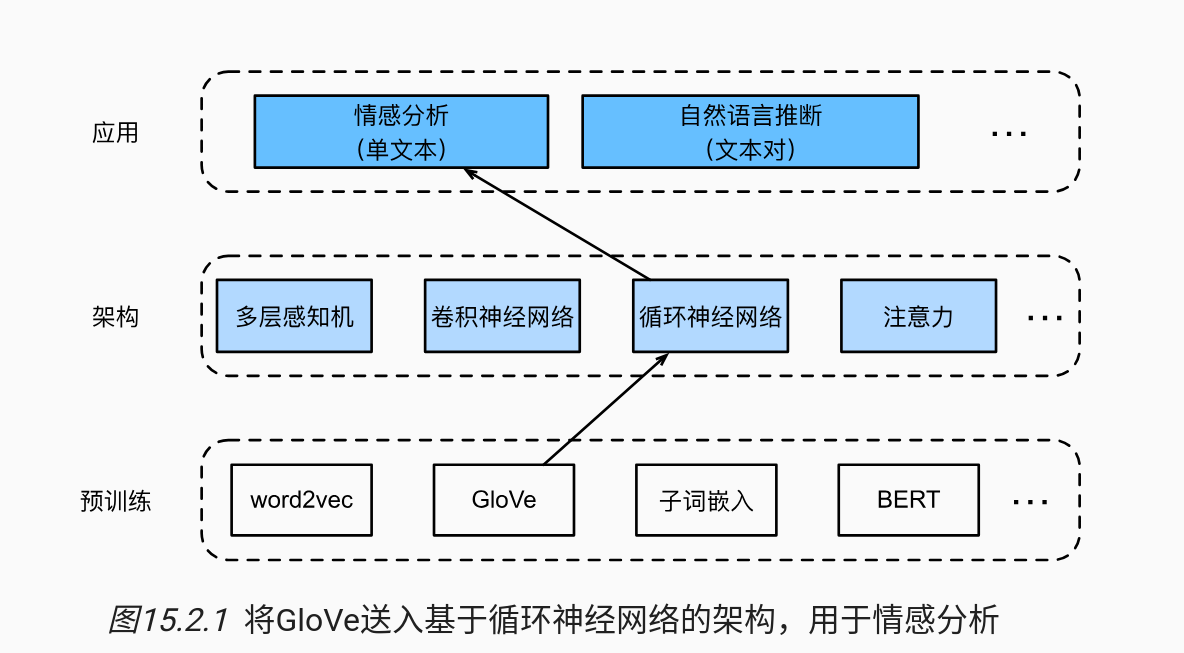

In [2]:
# # debug用
from data_preprocess import get_data
train_iter, test_iter, vocab = get_data()

read neg: 100%|██████████| 12500/12500 [00:00<00:00, 48281.78it/s]


Load raw data use time:0.592184086330235s


read neg: 100%|██████████| 12500/12500 [00:00<00:00, 72323.47it/s]


Load raw data use time:0.46204288583248854s
Build vocab....
Finish!
Build data-iter...
Finish!


In [3]:
print(len(vocab))

76835


In [4]:
# Test
x = torch.rand((100,50))
print(x.permute(1,0) == x.T)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


In [5]:
class BiRNN(nn.Module):
    """双向RNN"""
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


In [6]:
# 权重初始化函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

In [7]:
# 搭建网络
embed_size, num_hiddens, num_layers = 100, 100, 2
# devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights)


BiRNN(
  (embedding): Embedding(76835, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [8]:
# 使用预训练的embedding层
from embed_layer import TokenEmbedding
glove_embedding = TokenEmbedding('glove.6b.100d') # 100维，对应embed_size

In [9]:
# 测试
embeds = glove_embedding[vocab.idx_to_token]
print(embeds.shape)

# 加载
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

torch.Size([76835, 100])


In [10]:
from torchinfo import summary
input = torch.ones((1,500),dtype = torch.long).to(next(net.parameters()).device)
print(summary(net,input_data = input))

Layer (type:depth-idx)                   Output Shape              Param #
BiRNN                                    [1, 2]                    --
├─Embedding: 1-1                         [500, 1, 100]             (7,683,500)
├─LSTM: 1-2                              [500, 1, 200]             403,200
├─Linear: 1-3                            [1, 2]                    802
Total params: 8,087,502
Trainable params: 404,002
Non-trainable params: 7,683,500
Total mult-adds (G): 4.04
Input size (MB): 0.00
Forward/backward pass size (MB): 1.20
Params size (MB): 32.35
Estimated Total Size (MB): 33.55


In [11]:
# 计算准确率
def accurancy(net,data_iter,device):
    """计算准确率"""
    net.eval()
    total_nums = 0
    correct_nums = 0
    for batch in data_iter:
        X,Y = batch[0],batch[1]
        X = X.to(device)
        Y = Y.to(device)
        y_pred = net(X).argmax(dim = 1)
        correct_nums += (y_pred == Y).sum().item()
        total_nums += X.shape[0]
    return correct_nums / total_nums

# 定义训练函数
def train(net,trainer:torch.optim.Adam,train_iter,test_iter,loss_fn,lr,num_epochs,device_idx = None):
    """训练情感分析模型"""
    # 设置设备
    if device_idx == None:
        device = try_gpu(i = 0)
    else:
        device = try_gpu(device_idx)
    
    # 加载网络
    net = net.to(device)

    # 开始训练
    loss_plt = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        net.train() # 循环涉及评估，则每次循环前要net.train()
        loop = tqdm(train_iter,desc = f"Epoch:[{epoch + 1}/{num_epochs}]",
                    total = len(train_iter))
        loss_temp = 0
        total_nums = 0
        for batch in loop:
            # 清空梯度
            trainer.zero_grad()

            # forward
            X,Y = batch
            X = X.to(device)
            Y = Y.to(device)
            # print(X.shape,Y.shape)
            y_pred = net(X)
            total_nums += X.shape[0]

            # count loss and backwar
            loss = loss_fn(y_pred,Y)
            loss.sum().backward()
            trainer.step()

            # 先step后再调用item()，否则切断计算图
            loss_temp += loss.sum().item()
            
            # # update parameters
            # trainer.step()
            loop.set_postfix({"LOSS" : loss_temp / total_nums,"lr" : "{:e}".format(trainer.param_groups[0]['lr'])})
        print("Counting accurancy...")
        train_acc = accurancy(net,train_iter,device)
        test_acc = accurancy(net,test_iter,device)
        print(f"train acc:{train_acc}")
        print(f"test acc:{test_acc}")
        loss_plt.append(loss_temp / total_nums)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    return loss_plt,train_accs,test_accs

In [14]:
# 训练超参数
lr, num_epochs = 0.01, 20
loss = nn.CrossEntropyLoss(reduction = 'none') # 返回每个样本的损失，即reduction = 'None'
trainer = torch.optim.Adam(net.parameters(),lr = lr)
plt_collections = train(net,trainer,train_iter,test_iter,loss,lr,num_epochs,device_idx = 6)

Epoch:[1/20]: 100%|██████████| 391/391 [00:08<00:00, 45.45it/s, LOSS=0.618, lr=1.000000e-02]


Counting accurancy...
train acc:0.81
test acc:0.80936


Epoch:[2/20]: 100%|██████████| 391/391 [00:08<00:00, 47.86it/s, LOSS=0.419, lr=1.000000e-02]


Counting accurancy...
train acc:0.84372
test acc:0.83216


Epoch:[3/20]: 100%|██████████| 391/391 [00:08<00:00, 48.23it/s, LOSS=0.369, lr=1.000000e-02]


Counting accurancy...
train acc:0.86384
test acc:0.84456


Epoch:[4/20]: 100%|██████████| 391/391 [00:08<00:00, 47.70it/s, LOSS=0.332, lr=1.000000e-02]


Counting accurancy...
train acc:0.8816
test acc:0.85204


Epoch:[5/20]: 100%|██████████| 391/391 [00:08<00:00, 47.53it/s, LOSS=0.305, lr=1.000000e-02]


Counting accurancy...
train acc:0.89704
test acc:0.85708


Epoch:[6/20]: 100%|██████████| 391/391 [00:08<00:00, 48.19it/s, LOSS=0.282, lr=1.000000e-02]


Counting accurancy...
train acc:0.8966
test acc:0.84368


Epoch:[7/20]: 100%|██████████| 391/391 [00:08<00:00, 47.22it/s, LOSS=0.249, lr=1.000000e-02]


Counting accurancy...
train acc:0.92304
test acc:0.85208


Epoch:[8/20]: 100%|██████████| 391/391 [00:08<00:00, 47.27it/s, LOSS=0.224, lr=1.000000e-02]


Counting accurancy...
train acc:0.91496
test acc:0.84404


Epoch:[9/20]: 100%|██████████| 391/391 [00:08<00:00, 46.82it/s, LOSS=0.21, lr=1.000000e-02] 


Counting accurancy...
train acc:0.94028
test acc:0.8516


Epoch:[10/20]: 100%|██████████| 391/391 [00:08<00:00, 48.09it/s, LOSS=0.183, lr=1.000000e-02]


Counting accurancy...
train acc:0.94232
test acc:0.8428


Epoch:[11/20]: 100%|██████████| 391/391 [00:08<00:00, 47.69it/s, LOSS=0.17, lr=1.000000e-02] 


Counting accurancy...
train acc:0.94664
test acc:0.8474


Epoch:[12/20]: 100%|██████████| 391/391 [00:08<00:00, 47.43it/s, LOSS=0.157, lr=1.000000e-02]


Counting accurancy...
train acc:0.96092
test acc:0.8484


Epoch:[13/20]: 100%|██████████| 391/391 [00:08<00:00, 48.25it/s, LOSS=0.143, lr=1.000000e-02]


Counting accurancy...
train acc:0.96424
test acc:0.85168


Epoch:[14/20]: 100%|██████████| 391/391 [00:07<00:00, 52.62it/s, LOSS=0.144, lr=1.000000e-02]


Counting accurancy...
train acc:0.9532
test acc:0.84196


Epoch:[15/20]: 100%|██████████| 391/391 [00:06<00:00, 56.73it/s, LOSS=0.131, lr=1.000000e-02]


Counting accurancy...
train acc:0.95332
test acc:0.839


Epoch:[16/20]: 100%|██████████| 391/391 [00:07<00:00, 54.42it/s, LOSS=0.112, lr=1.000000e-02] 


Counting accurancy...
train acc:0.9656
test acc:0.83928


Epoch:[17/20]: 100%|██████████| 391/391 [00:07<00:00, 51.59it/s, LOSS=0.106, lr=1.000000e-02] 


Counting accurancy...
train acc:0.9746
test acc:0.8418


Epoch:[18/20]: 100%|██████████| 391/391 [00:07<00:00, 55.22it/s, LOSS=0.105, lr=1.000000e-02] 


Counting accurancy...
train acc:0.9722
test acc:0.84484


Epoch:[19/20]: 100%|██████████| 391/391 [00:07<00:00, 53.20it/s, LOSS=0.095, lr=1.000000e-02] 


Counting accurancy...
train acc:0.97332
test acc:0.84116


Epoch:[20/20]: 100%|██████████| 391/391 [00:07<00:00, 53.85it/s, LOSS=0.0877, lr=1.000000e-02]


Counting accurancy...
train acc:0.95956
test acc:0.82996


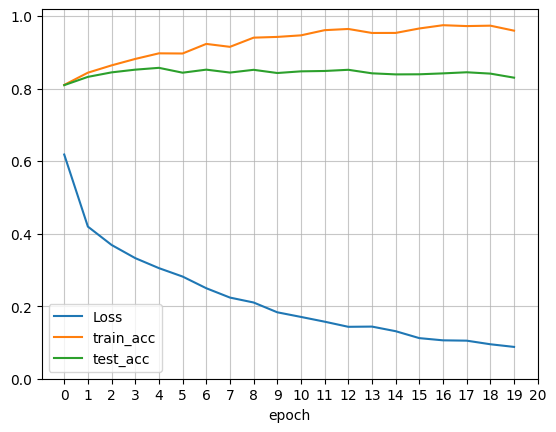

In [15]:
import matplotlib.pyplot as plt
import numpy as np
loss_plt,train_acc_plt,test_acc_plt = plt_collections
plt.plot(np.arange(num_epochs),loss_plt,label = 'Loss')
plt.plot(np.arange(num_epochs),train_acc_plt,label = 'train_acc')
plt.plot(np.arange(num_epochs),test_acc_plt,label = 'test_acc')
plt.xlabel("epoch")

# 设置主要和次要刻度
plt.xticks(np.arange(0, num_epochs + 1, 1))  # 主刻度每1单位
plt.yticks(np.arange(0, 1.1, 0.2))  # Y轴每0.5单位

# 添加主要网格和次要网格
plt.grid(True, which='major', linestyle='-', alpha=0.7)
plt.legend()
plt.show()

In [16]:
import os
save_prefix = "results/rnn"
os.makedirs(save_prefix,exist_ok = True)
torch.save(net,os.path.join(save_prefix,"exp2.pt"))

In [17]:
# 保存结果数据
import joblib
plot_prefix = "plots/rnn"
os.makedirs(plot_prefix,exist_ok = True)
joblib.dump(plt_collections,os.path.join(plot_prefix,"exp2-20epoch.joblib"))

['plots/rnn/exp2-20epoch.joblib']

**三、效果预测**

In [69]:
def predict(input,vocab:Vocab,net):
    net.eval()
    device = next(net.parameters()).device
    input = [vocab[word] for word in input.split()]
    input = torch.tensor(
        truncate_pad(input,num_steps = 500,padding_token = vocab['<pad>'])).unsqueeze(0) 
    # shape = (batch_size,num_steps)
    y_pred = torch.argmax(net(input.to(device)),dim = 1).squeeze(0).item()
    return "positive" if y_pred == 1 else "negative"
    

In [ ]:
print(predict("the movie is bad",vocab,net))
print(predict("the movie is good",vocab,net))
print(predict("this movie is so great",vocab,net))
print(predict("I'm a male, not given to women's movies, but this is really a well done special story. I have no personal love for Jane Fonda as a person but she does one Hell of a fine job, while DeNiro is his usual superb self. Everything is so well done: acting, directing, visuals, settings, photography, casting. If you can enjoy a story of real people and real love - this is a winner.",vocab,net))

negative
negative
positive
positive


In [80]:
print(predict("good",vocab,net))
print(predict("Bad",vocab,net))
print(predict("fantastic",vocab,net))

positive
negative
positive
